In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
sales_df = pd.read_csv("./sales.csv",sep=";")
categories_df = pd.read_csv("./categories.csv",sep=";")
traffic_df = pd.read_csv("./traffic.csv",sep=";")

In [3]:
sales_df.head()

,week_starting_date,product_id,sales
0,20191209,1990,1
1,20201123,1990,1
2,20201207,1990,1
3,20191202,1990,1
4,20201109,1990,2


In [4]:
categories_df.head()

,product_id,category_id
0,1990,0
1,2361,1
2,1085,2
3,3091,3
4,955,4


In [5]:
traffic_df.head()

,week_starting_date,product_id,traffic
0,20190107,1990,1
1,20190107,2361,7
2,20190107,1085,1
3,20190107,3091,4
4,20190107,955,12


In [6]:
df = sales_df.merge(categories_df, on='product_id', how='inner').merge(traffic_df, on='product_id', how='inner')
df.head()

,week_starting_date_x,product_id,sales,category_id,week_starting_date_y,traffic
0,20191209,1990,1,0,20190107,1
1,20191209,1990,1,0,20190121,1
2,20191209,1990,1,0,20190218,1
3,20191209,1990,1,0,20190325,1
4,20191209,1990,1,0,20190408,1


In [7]:
df.rename(columns={'week_starting_date_x':'week_starting_date_sales',
                   'week_starting_date_y':'week_starting_date_traffic'},inplace=True)

In [8]:
df.describe()

,week_starting_date_sales,product_id,sales,category_id,week_starting_date_traffic,traffic
count,8.404080e+06,8.404080e+06,8.404080e+06,8.404080e+06,8.404080e+06,8.404080e+06
mean,2.019607e+07,1.529987e+03,2.966780e+01,2.572863e+01,2.019620e+07,2.316073e+01
std,4.978939e+03,9.031579e+02,1.003518e+02,1.876078e+01,4.977439e+03,8.162615e+01
min,2.019011e+07,1.000000e+00,1.000000e+00,0.000000e+00,2.019011e+07,1.000000e+00
25%,2.019080e+07,7.270000e+02,5.000000e+00,1.000000e+01,2.019073e+07,3.000000e+00
50%,2.020013e+07,1.513000e+03,9.000000e+00,2.200000e+01,2.020021e+07,7.000000e+00
75%,2.020072e+07,2.292000e+03,2.200000e+01,3.600000e+01,2.020073e+07,1.700000e+01
max,2.020123e+07,3.135000e+03,5.465000e+03,9.100000e+01,2.020123e+07,9.914000e+03


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8404080 entries, 0 to 8404079
Data columns (total 6 columns):
 #   Column                      Dtype
---  ------                      -----
 0   week_starting_date_sales    int64
 1   product_id                  int64
 2   sales                       int64
 3   category_id                 int64
 4   week_starting_date_traffic  int64
 5   traffic                     int64
dtypes: int64(6)
memory usage: 448.8 MB


In [10]:
df.head()

,week_starting_date_sales,product_id,sales,category_id,week_starting_date_traffic,traffic
0,20191209,1990,1,0,20190107,1
1,20191209,1990,1,0,20190121,1
2,20191209,1990,1,0,20190218,1
3,20191209,1990,1,0,20190325,1
4,20191209,1990,1,0,20190408,1


In [11]:
df2 = df.copy(deep=True)

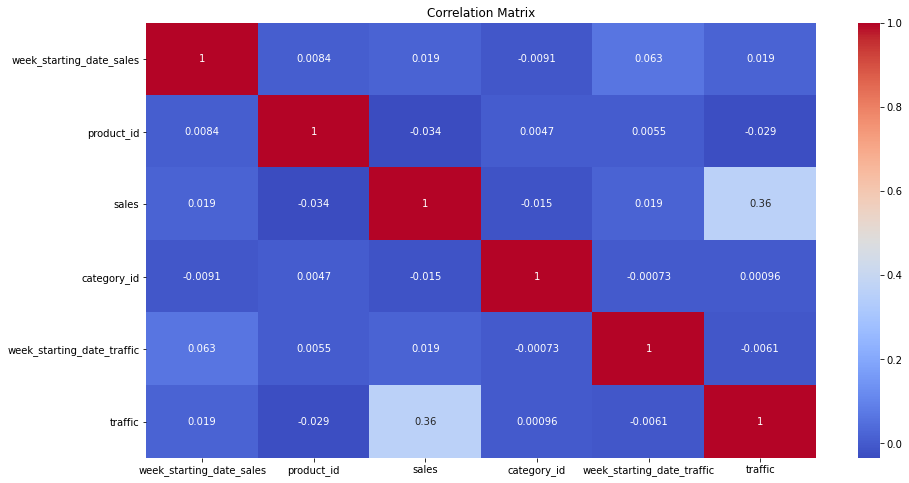

In [12]:
plt.figure(figsize=(15,8))
sns.heatmap(df2.corr(), annot=True,cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [13]:
df2['week_starting_date_sales'] = pd.to_datetime(df2['week_starting_date_sales'], format='%Y%m%d')
df2['week_starting_date_traffic'] = pd.to_datetime(df2['week_starting_date_traffic'], format='%Y%m%d')

In [14]:
df2['year_sales'] = df2['week_starting_date_sales'].dt.year
df2['month_sales'] = df2['week_starting_date_sales'].dt.month
df2['year_traffic'] = df2['week_starting_date_traffic'].dt.year
df2['month_traffic'] = df2['week_starting_date_traffic'].dt.month

<AxesSubplot:title={'center':'Sales by Year'}, xlabel='Years', ylabel='Sales in billions'>

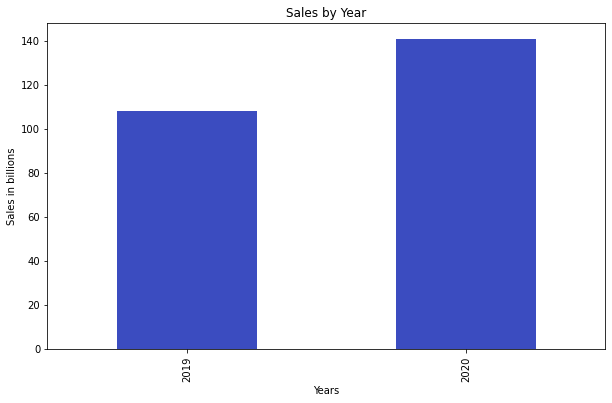

In [15]:
sales_year = df2.groupby('year_sales').agg(sales_target =('sales','sum'))
sales_year=sales_year/1000000
sales_year.plot(kind='bar', title = 'Sales by Year', figsize = (10,6), cmap='coolwarm', xlabel="Years",ylabel="Sales in billions",legend=False)

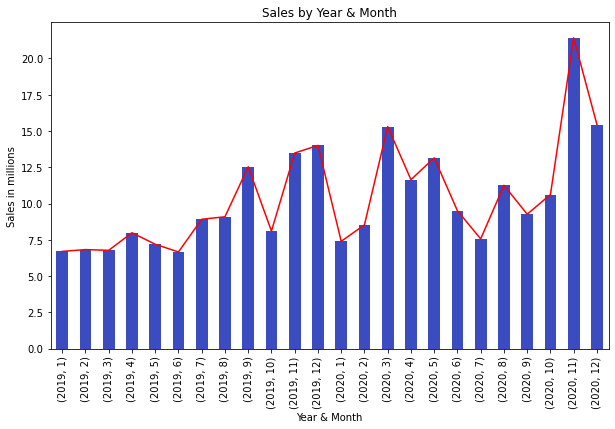

In [16]:
sales_year_month = df2.groupby(['year_sales','month_sales']).agg(sales_target =('sales','sum'))
sales_year_month=sales_year_month/1000000
ax=sales_year_month.plot(kind='line', title = 'Sales by Year & Month', figsize = (10,6), color='red', xlabel="Year & Month",ylabel="Sales in millions",legend=False)
sales_year_month.plot(kind='bar', title = 'Sales by Year & Month', figsize = (10,6), cmap='coolwarm', xlabel="Year & Month",ylabel="Sales in millions",legend=False,ax=ax);

<AxesSubplot:title={'center':'Best 10 selling product_id'}, xlabel='product ID', ylabel='Sales in millions'>

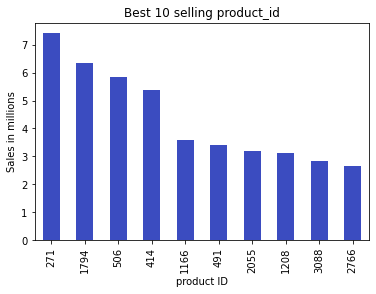

In [20]:
best_product = pd.DataFrame(df2.groupby('product_id').sum()['sales'])
best_product.sort_values(by=['sales'], inplace=True, ascending=False)
top_prods = best_product.head(10)
top_prods=top_prods/1000000
top_prods.plot(kind="bar", title = 'Best 10 selling product_id', cmap='coolwarm', xlabel="Product ID",ylabel="Sales in millions",legend=False)

<AxesSubplot:title={'center':'Best 10 selling category_id'}, xlabel='Category ID', ylabel='Sales in millions'>

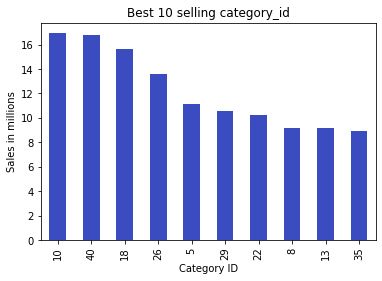

In [42]:
best_product = pd.DataFrame(df2.groupby('category_id').sum()['sales'])
best_product.sort_values(by=['sales'], inplace=True, ascending=False)
top_prods = best_product.head(10)
top_prods=top_prods/1000000
top_prods.plot(kind="bar", title = 'Best 10 selling category_id', cmap='coolwarm', xlabel="Category ID",ylabel="Sales in millions",legend=False)